# Plot histograms (High Density Scenario)

In [1]:
import os
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from IPython.display import display, HTML
%matplotlib inline

def parse_if_number(s):
    try: return float(s)
    except: return True if s=="true" else False if s=="false" else s if s else None

def parse_ndarray(s):
    return np.fromstring(s, sep=' ') if s else None

def get_file_name(name):
    return name.replace(':', '-')

## Config

In [2]:
inputFile = 'data.csv'
repetitionsCount = -1 # -1 = auto-detect
factors = ['R', 'T', 'm', 'D']

# Plots
histBinNum = 30 # Histograms
histCenter = True # Center distribution
plotSize = (10, 10)
plotStyle = 'seaborn-whitegrid'
# Save
saveFigures = False

# Filter scalars
scalarsFilter = ['Floorplan.userCount']

# Filter histograms
histFilter = ['Floorplan.copies:histogram', 'Floorplan.collisions:histogram', 'Floorplan.totalCollisions:histogram', 'Floorplan.msgsPerSlot:histogram']

histNames = [
    ('Floorplan.copies:histogram', 'Number of copies received by each user in an hear window', 1),
    ('Floorplan.collisions:histogram', 'Number of collisions received by the users', 1),
    ('Floorplan.totalCollisions:histogram', 'Number of colliding messages received by the users in each slot', 1),
    ('Floorplan.msgsPerSlot:histogram', 'Number of messages sent in each slot', 1),
]

## Load scalars

In [3]:
df = pd.read_csv('exported_data/' + inputFile, converters = {
    'attrvalue': parse_if_number,
    'binedges': parse_ndarray,
    'binvalues': parse_ndarray,
    'vectime': parse_ndarray,
    'vecvalue': parse_ndarray,
})

In [4]:
if repetitionsCount <= 0: # auto-detect
    repetitionsCount = int(df[df.attrname == 'repetition']['attrvalue'].max()) + 1
print('Repetitions:', repetitionsCount)

Repetitions: 10


In [5]:
scalars = df[(df.type == 'scalar') | ((df.type == 'itervar') & (df.attrname != 'TO')) | ((df.type == 'param') & (df.attrname == 'Floorplan.userCount')) | ((df.type == 'runattr') & (df.attrname == 'repetition'))]
scalars = scalars.assign(qname = scalars.attrname.combine_first(scalars.module + '.' + scalars.name))
for index, row in scalars[scalars.type == 'itervar'].iterrows():
    val = scalars.loc[index, 'attrvalue']
    if isinstance(val, str)  and not all(c.isdigit() for c in val):
        scalars.loc[index, 'attrvalue'] = eval(val)
scalars.value = scalars.value.combine_first(scalars.attrvalue.astype('float64'))
scalars_wide = scalars.pivot_table(index=['run'], columns='qname', values='value')
scalars_wide.sort_values([*factors, 'repetition'], inplace=True)
count = 0
for index in scalars_wide.index:
    config = count // repetitionsCount
    scalars_wide.loc[index, 'config'] = config
    count += 1
scalars_wide = scalars_wide[['config', 'repetition', *factors, *scalarsFilter]]

In [6]:
# Computed
factorsCount = len(factors)
configsCount = len(scalars_wide)//repetitionsCount
print('Configs:', configsCount)
totalSims = configsCount*repetitionsCount


display(HTML("<style>div.output_scroll { height: auto; max-height: 48em; }</style>"))
pd.set_option('display.max_rows', totalSims)
pd.set_option('display.max_columns', 100)
if saveFigures:
    os.makedirs('figures', exist_ok=True)

Configs: 16


## Load histograms

In [7]:
histograms = df[df.type == 'histogram']
histograms = histograms.assign(qname = histograms.module + '.' + histograms.name)
histograms = histograms[histograms.qname.isin(histFilter)]
for index in scalars_wide.index:
    r = index
    cfg = scalars_wide.loc[index, 'config']
    rep = scalars_wide.loc[index, 'repetition']
    histograms.loc[histograms.run == r, 'config'] = cfg
    histograms.loc[histograms.run == r, 'repetition'] = rep
    for histname, _, _ in histNames:
        histograms.loc[(histograms.run == r) & (histograms.qname == histname), 'binsize'] = histograms.loc[(histograms.run == r) & (histograms.qname == histname), 'binedges'].values[0][1] - histograms.loc[(histograms.run == r) & (histograms.qname == histname), 'binedges'].values[0][0]
        histograms.loc[(histograms.run == r) & (histograms.qname == histname), 'binmin'] = histograms.loc[(histograms.run == r) & (histograms.qname == histname), 'binedges'].values[0].min()
        histograms.loc[(histograms.run == r) & (histograms.qname == histname), 'binmax'] = histograms.loc[(histograms.run == r) & (histograms.qname == histname), 'binedges'].values[0].max()
histograms.sort_values(['config', 'repetition', 'qname'], inplace=True)

for cfg in range(0, configsCount):
    for histname, _, _ in histNames:
        histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binsizelcm'] = np.lcm.reduce(list(map(int, histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binsize'].values.tolist())))
        histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binminall'] = histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binmin'].min()
        histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binmaxall'] = histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binmax'].max()
histograms = histograms[['config', 'repetition', 'qname', 'binmin', 'binmax', 'binsize', 'binedges', 'binvalues', 'binminall', 'binmaxall', 'binsizelcm']]

## Compute means and ranges

In [8]:
def get_values_for_bin(hist, low, high):
    edges = hist['binedges'].values[0]
    values = hist['binvalues'].values[0]
    inbin = []
    lowidx = 0
    highidx = 0
    for edge in edges:
        if edge < low:
            lowidx += 1
        if edge < high:
            highidx += 1
            continue
        break
    minval = math.inf
    maxval = -math.inf
    for i in range(lowidx, highidx):
        if i > len(values) - 1:
            break
        inbin.append(values[i])
        if values[i] < minval:
            minval = values[i]
        if values[i] > maxval:
            maxval = values[i]
    if len(inbin) == 0:
        return (minval, 0, maxval)
    return (minval, sum(inbin) / len(inbin), maxval)
        

cols = ['config']
for histname, _, _ in histNames:
    name = histname[histname.index('.')+1:histname.index(':')]
    cols.append(name + 'Bins')
    cols.append(name + 'MeanValues')
    cols.append(name + 'LowValues')
    cols.append(name + 'HighValues')
data = []
for cfg in range(0, configsCount):
    curdata = [cfg]
    for histname, _, stepMultiplier in histNames:
        binmin = int(histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binminall'].values[0])
        binstep = int(stepMultiplier) * int(histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binsizelcm'].values[0])
        binmax = 1 + int(histograms.loc[(histograms.config == cfg) & (histograms.qname == histname), 'binmaxall'].values[0])
        bins = np.arange(binmin, binmax, binstep)
        totalSize = (binmax - binmin - 1)//binstep
        meanValues = np.zeros(totalSize)
        lowValues = np.full(totalSize, math.inf)
        highValues = np.full(totalSize, -math.inf)
        for rep in range(0, repetitionsCount):
            curHist = histograms[(histograms.config == cfg) & (histograms.qname == histname) & (histograms.repetition == rep)]
            num = 0
            for binlow, binhigh in zip(range(binmin, binmax - 1, binstep), range(binmin + binstep, binmax + binstep, binstep)):
                values = get_values_for_bin(curHist, binlow, binhigh)
                if lowValues[num] > values[0]:
                    lowValues[num] = values[0]
                meanValues[num] += values[1]
                if highValues[num] < values[2]:
                    highValues[num] = values[2]
                num += 1
        for i in range(0, len(meanValues)):
            meanValues[i] = meanValues[i] / repetitionsCount
        curdata.append(bins)
        curdata.append(meanValues)
        curdata.append(lowValues)
        curdata.append(highValues)
    data.append(curdata)
plotdf = pd.DataFrame.from_records(data, columns=cols, index='config')

## Plots

Config 0


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-0-20210526-15:28:05-4471,0.0,10.0,5.0,3.0,5.0


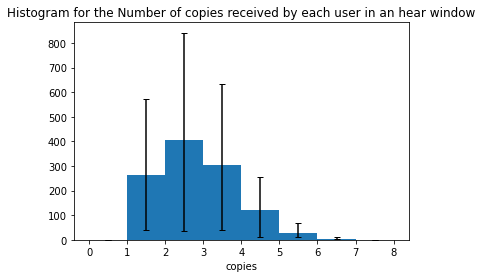

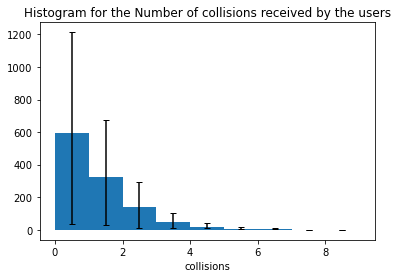

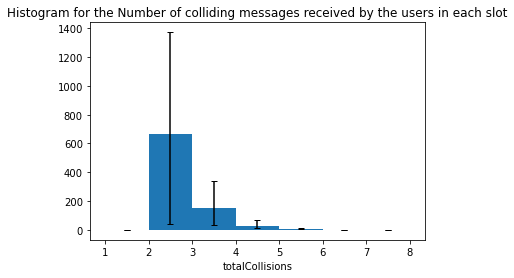

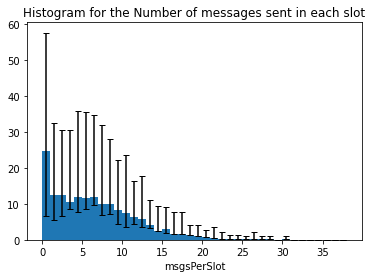

#######################

Config 1


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-40-20210526-15:29:00-4888,1.0,10.0,5.0,3.0,10.0


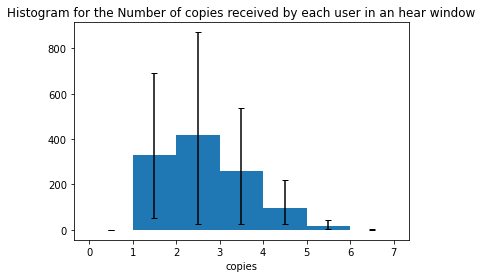

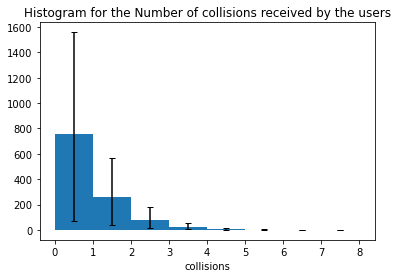

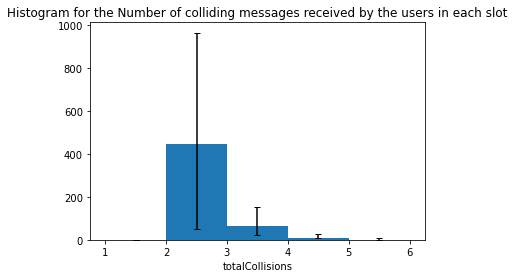

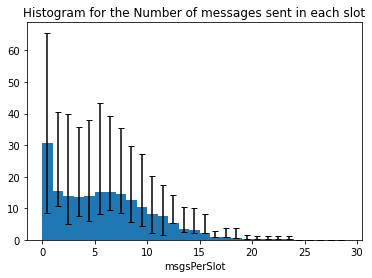

#######################

Config 2


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-20-20210526-15:28:05-4475,2.0,10.0,5.0,7.0,5.0


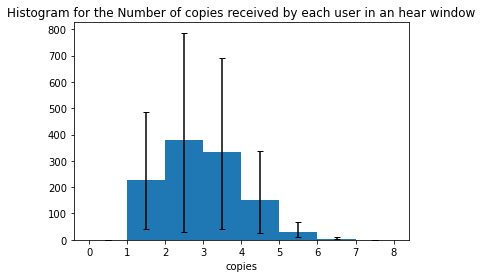

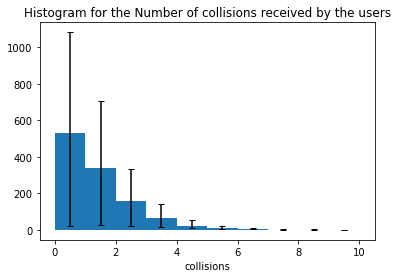

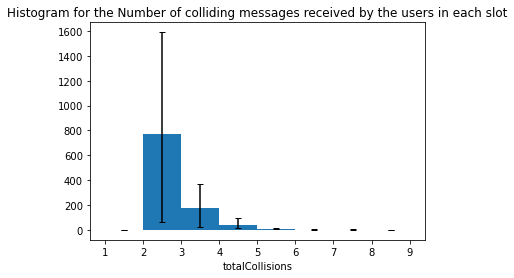

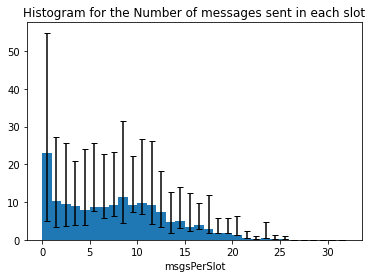

#######################

Config 3


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-60-20210526-15:29:08-4908,3.0,10.0,5.0,7.0,10.0


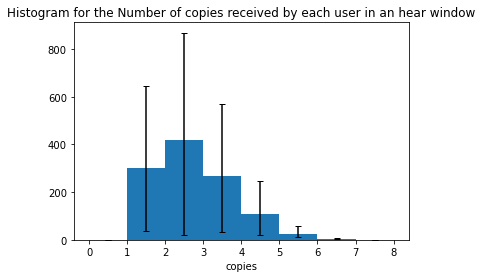

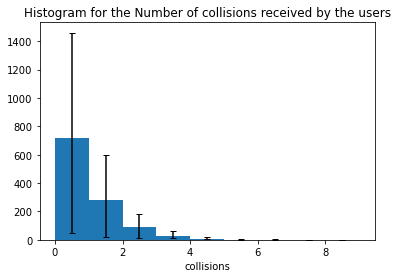

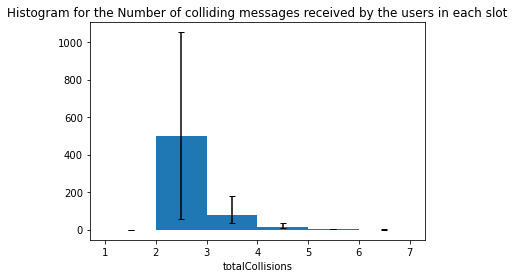

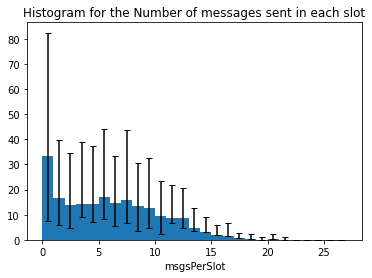

#######################

Config 4


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-80-20210526-15:29:51-5058,4.0,10.0,10.0,3.0,5.0


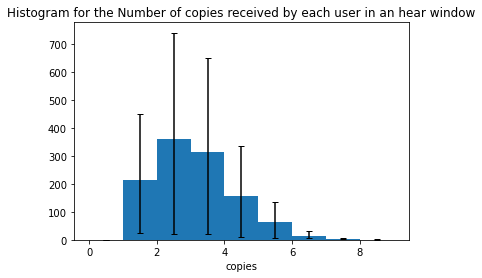

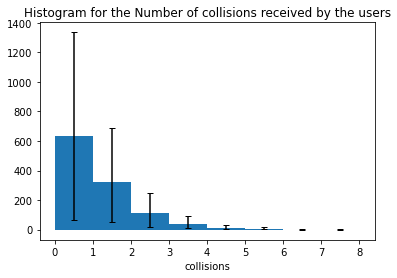

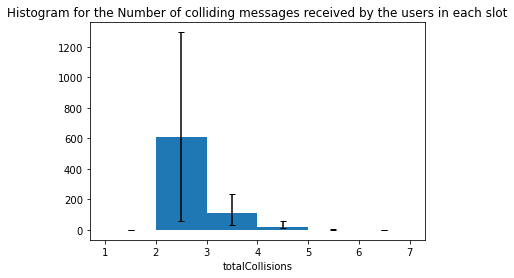

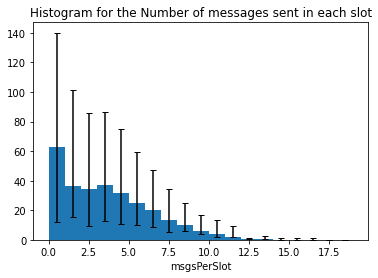

#######################

Config 5


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-120-20210526-15:30:31-5164,5.0,10.0,10.0,3.0,10.0


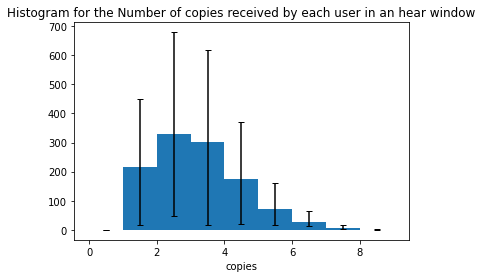

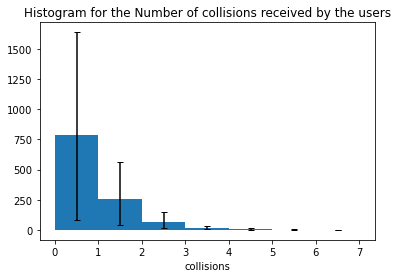

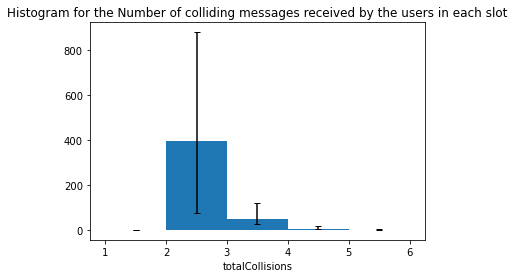

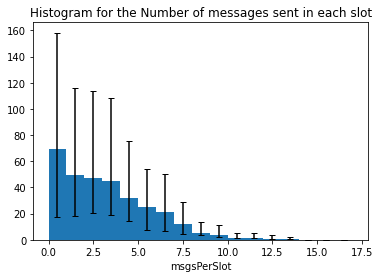

#######################

Config 6


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-100-20210526-15:30:09-5105,6.0,10.0,10.0,7.0,5.0


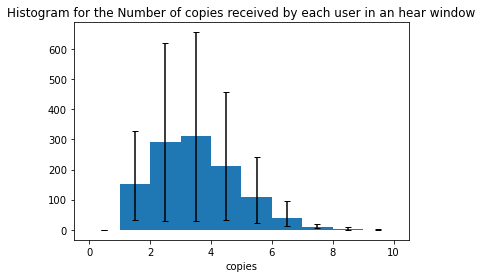

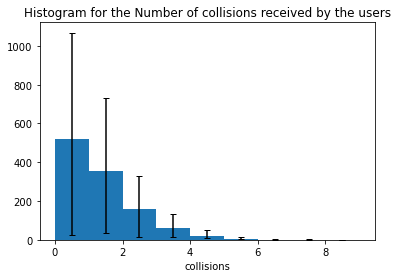

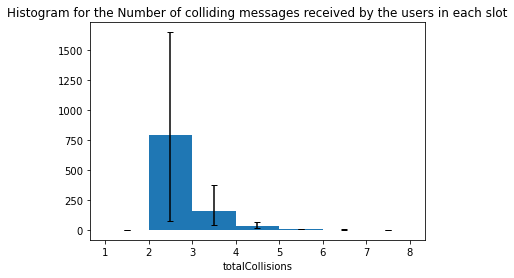

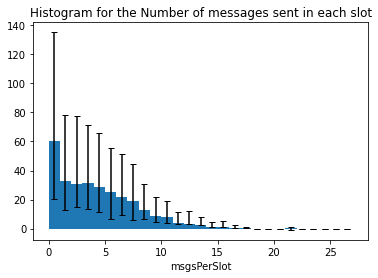

#######################

Config 7


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-140-20210526-15:31:07-5255,7.0,10.0,10.0,7.0,10.0


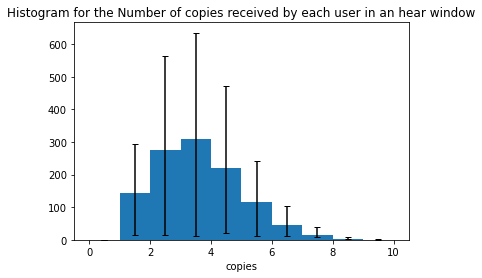

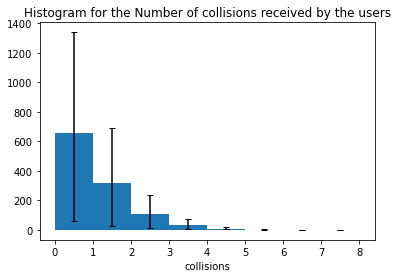

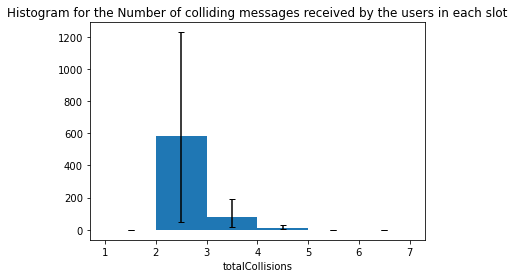

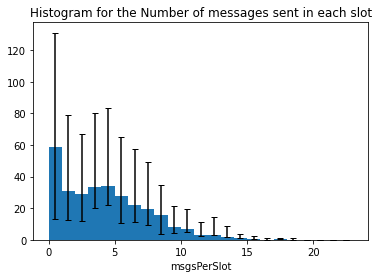

#######################

Config 8


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-10-20210526-15:28:05-4473,8.0,20.0,5.0,3.0,5.0


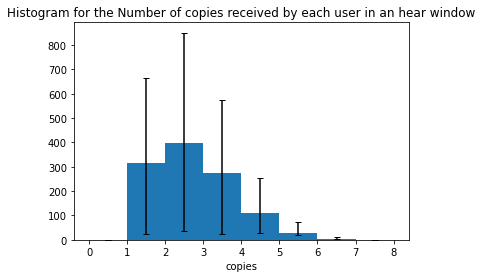

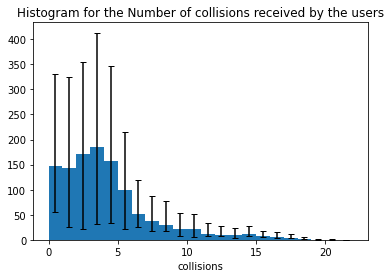

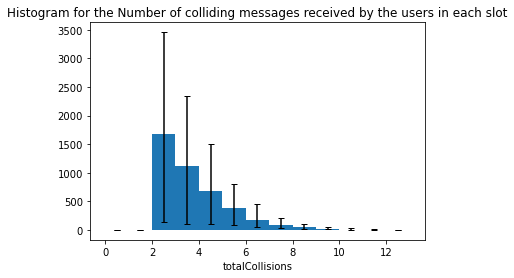

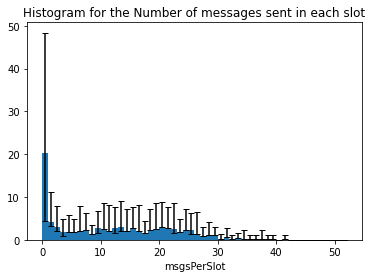

#######################

Config 9


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-50-20210526-15:29:01-4894,9.0,20.0,5.0,3.0,10.0


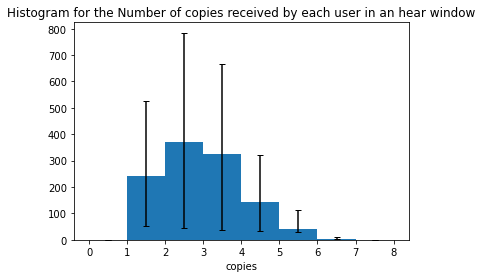

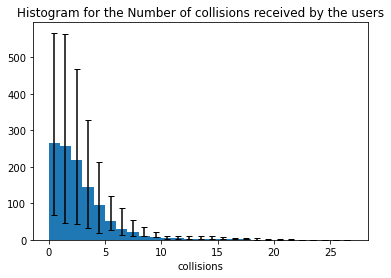

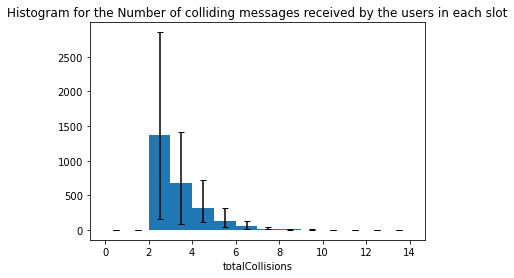

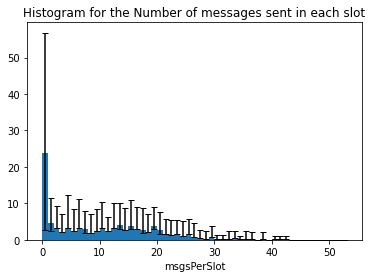

#######################

Config 10


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-30-20210526-15:28:05-4477,10.0,20.0,5.0,7.0,5.0


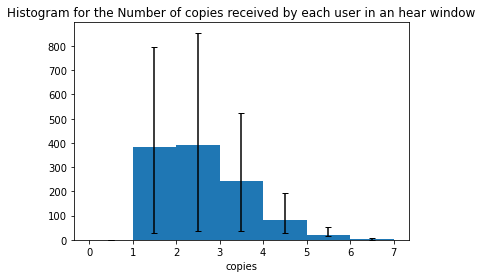

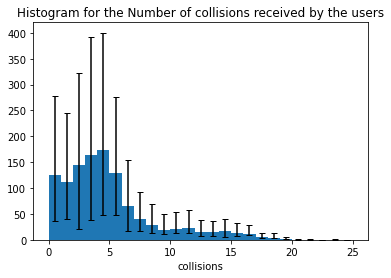

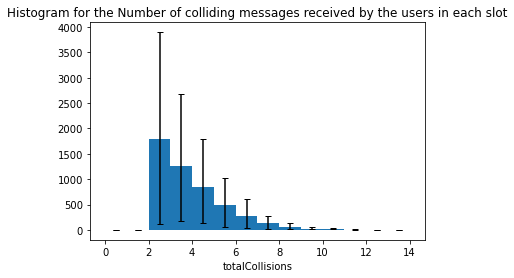

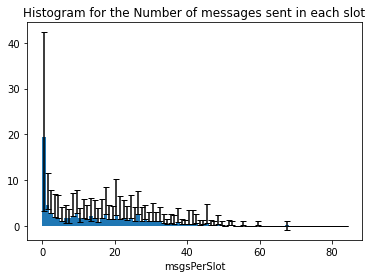

#######################

Config 11


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-70-20210526-15:29:09-4912,11.0,20.0,5.0,7.0,10.0


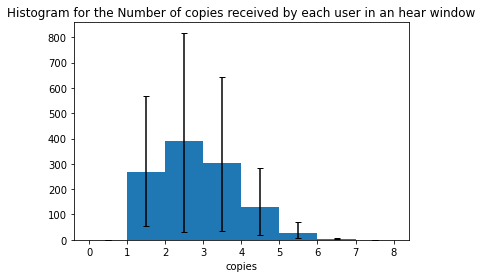

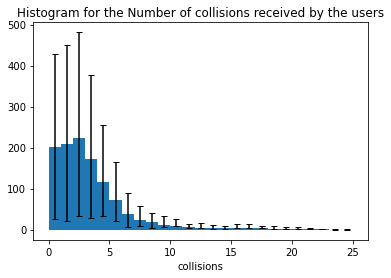

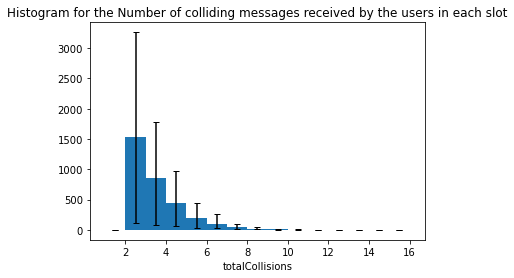

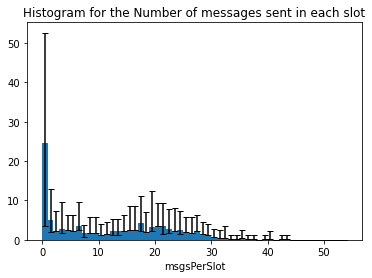

#######################

Config 12


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-90-20210526-15:29:55-5068,12.0,20.0,10.0,3.0,5.0


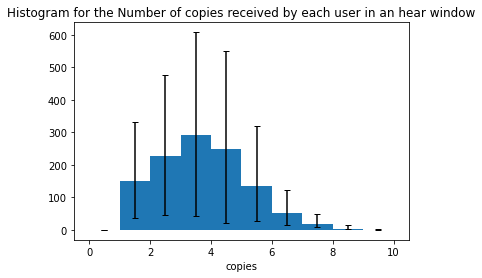

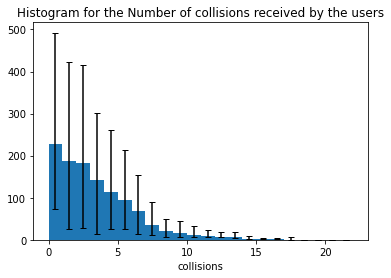

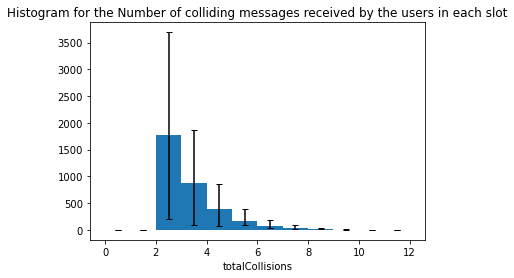

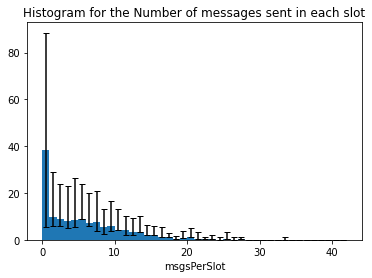

#######################

Config 13


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-130-20210526-15:30:38-5193,13.0,20.0,10.0,3.0,10.0


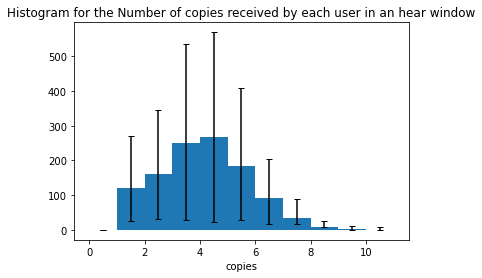

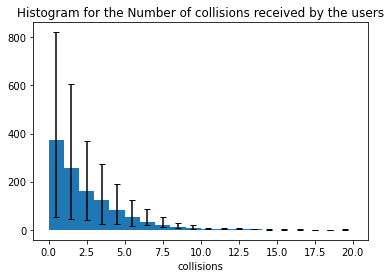

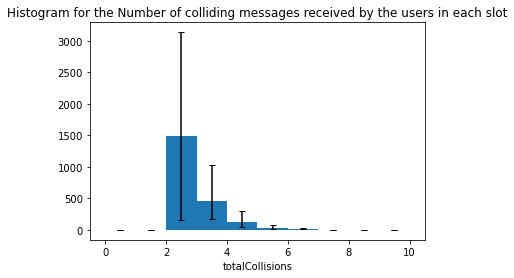

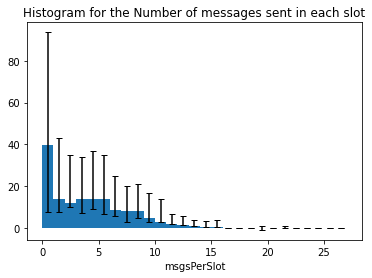

#######################

Config 14


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-110-20210526-15:30:10-5109,14.0,20.0,10.0,7.0,5.0


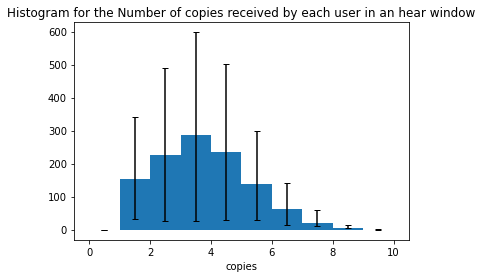

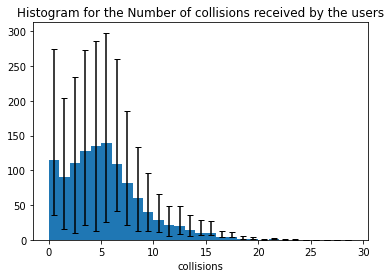

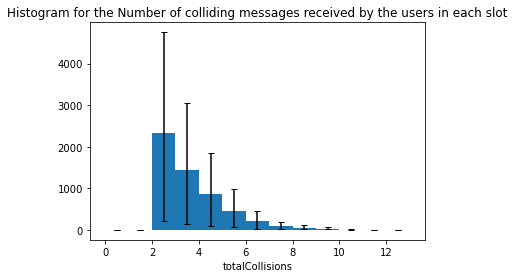

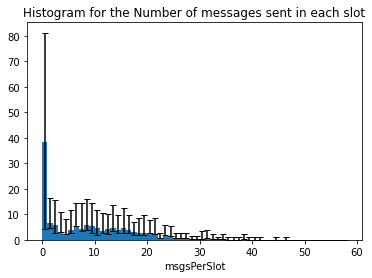

#######################

Config 15


qname,config,R,T,m,D
run,,,,,
HighDensity2kr-150-20210526-15:31:10-5261,15.0,20.0,10.0,7.0,10.0


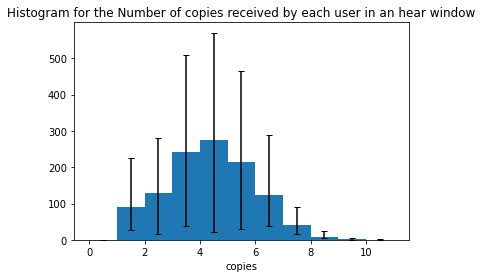

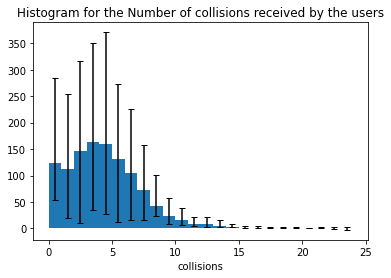

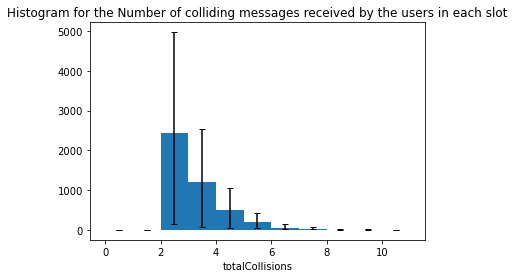

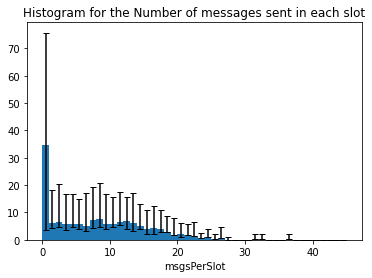

#######################



In [9]:
for cfg, hist in plotdf.iterrows():
    print('Config ' + str(cfg))
    display(scalars_wide.loc[(scalars_wide.repetition == 0) & (scalars_wide.config == cfg)][['config', *factors]])
    for histName, histDesc, _ in histNames:
        name = histName[histName.index('.')+1:histName.index(':')]
        bins = hist[name + 'Bins']
        means = hist[name + 'MeanValues']
        lows = hist[name + 'LowValues']
        highs = hist[name + 'HighValues']
        bincenters = 0.5*(bins[1:]+bins[:-1])
        ranges = [x for x in zip(lows, highs)]
        ranges = np.array(ranges).T
        plt.bar(bincenters, means, width=1, yerr=ranges, error_kw={'capsize': 3})
        plt.title('Histogram for the ' + histDesc)
        plt.xlabel(name)
        if saveFigures:
            fig = plt.gcf()
            fig.savefig('figures/' + get_file_name(histName) + '-' + str(cfg) + '-perfplot.png')
        plt.show()
    print('#######################')
    print()

## Notes

We note that the range `3-7` for the maxCopies (`m`) parameter is valid in this scenario. In fact, if we see at the `copies` histograms above, we can see that `m=3` means that the users often don't relay the message (`copies` is frequently above `maxCopies`) while `m=7` only in some rare cases (but **not** never) the users don't relay the message.

This is interesting since we can study the difference when the users often decide to not relay the message compared to when they just rarely decide to not relay it.